# Sync Code

Clone the GitHub Repo

In [45]:
!cd /content
!git clone https://github.com/szappac20/training_camp_21_22.git -b develop

fatal: destination path 'training_camp_21_22' already exists and is not an empty directory.


Move to the Python Project root folder and install requirements

In [46]:
%cd /content/training_camp_21_22
%pip install --upgrade -r requirements.txt -qqq

/content/training_camp_21_22


# Download Dataset from Kaggle competition

Download dataset from Kaggle competition pitc-2122-prediction

In [47]:
!mkdir -p ~/.kaggle

Download the kaggle.json token file

Download the input file (training and test)

In [48]:
!mkdir -p data/task_1
!mkdir -p data/task_2

In [49]:
%cd data/task_1

/content/training_camp_21_22/data/task_1


In [ ]:
!kaggle competitions download -c pitc-2122-clustering
!unzip pitc-2122-clustering.zip

  0% 0.00/23.1M [00:00<?, ?B/s]
100% 23.1M/23.1M [00:00<00:00, 291MB/s]
Archive:  pitc-2122-clustering.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
%cd ../task_2

/content/training_camp_21_22/data/task_2


In [ ]:
!kaggle competitions download -c pitc-2122-prediction
!unzip pitc-2122-prediction.zip

 82% 65.0M/79.3M [00:00<00:00, 147MB/s]
100% 79.3M/79.3M [00:00<00:00, 124MB/s]
Archive:  pitc-2122-prediction.zip
  inflating: solution_sample.csv     
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
%cd /content/training_camp_21_22

/content/training_camp_21_22


# Import packages

Move back to the Python project folder

In [50]:
import sys
import os

sys.path.append("training_camp_21_22")

Import libraries

In [51]:
import datetime
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import itertools

import csv
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import training_camp_21_22.config
import training_camp_21_22.models

import training_camp_21_22.models.baseline
import training_camp_21_22.data.window_generator

# Preprocess Data

Parse the data (see the previous task!)

In [ ]:
# Parse the csv file with json entries

def convert_json_2_pd(json_input_path, train = True):
    """
    Read the csv file and extract from json events
    any feature useful to classify the consumer consumption profile 
    """
    csv_df = pd.DataFrame(columns=[
      "userID",
      "legalNature",
      "citizenshipNoUSA",
      "billing_range.from_date",
      "billing_range.to_date",
      "fasciaF0ConsumoFatturato",
      "fasciaF1ConsumoFatturato",
      "fasciaF2ConsumoFatturato",
      "fasciaF3ConsumoFatturato",
      "fasciaF4ConsumoFatturato",
      "fasciaF5ConsumoFatturato",
      "fasciaF6ConsumoFatturato",
      "res_address_code",
      "res_address_value",
      "dom_address_code",
      "dom_address_value"
    ])


    d = {}
    labels = {}
    i = 0
    j = 0
    with open(json_input_path) as csvfile:

        reader = csv.reader(csvfile, delimiter=',')
        next(reader)

        for row in tqdm(reader):
          # iterate through bill

          for bill in json.loads(row[-1]) :
            # read consumer id
            id = row[0]

            # billing_range
            billing_range = bill['customData']['billing_range']
            energy = bill['customData']['energy']
            addresses = bill['bamData']['items']['bamItem']['addresses']
            
            res_address_code = ''
            res_address_value = ''
            dom_address_code = ''
            dom_address_value = ''

            # build the fields
            for addr in addresses:
              if(addr['type']['code'] == '2'):
                res_address_code = addr['city']['code']
                res_address_value = addr['city']['value']
              elif(addr['type']['code'] == '6'):
                dom_address_code = addr['city']['code']
                dom_address_value = addr['city']['value']
            

            d[i] = {
              'userID' : id,
              'legalNature' : bill['bamData']['items']['bamItem']['legalNature'],
              'citizenshipNoUSA' : bill['bamData']['items']['bamItem']['personInfo']['citizenshipNoUSA'],
              'billing_range.from_date' : billing_range['from_date'],
              'billing_range.to_date' : billing_range['to_date'],
              'f1' : energy['fasciaF1ConsumoFatturato'],
              'f2' : energy['fasciaF2ConsumoFatturato'],
              'f3' : energy['fasciaF3ConsumoFatturato'],
              'res_address_code': res_address_code,
              'res_address_value': res_address_value,
              'dom_address_code': dom_address_code,
              'dom_address_value': dom_address_value
            }
            i = i+1

          if(train):
            labels[j] = {'userID' : row[0] , 'cluster': int(row[1])}
            j += 1


    if(train):
      return pd.DataFrame.from_dict(d, "index"), pd.DataFrame.from_dict(labels, 'index')
    return  pd.DataFrame.from_dict(d, "index")


features_df, labels_df = convert_json_2_pd(json_input_path="/content/training_camp_21_22/data/task_1/train.csv")

70000it [00:21, 3260.90it/s]


Fill the missing data (for the data coming from the past history)

# Model

Define a function for train and evaluate 

In [ ]:
def train_evaluate_model(
        model, train_window, plot_window,
        val_performance, test_performance):

    history = model.compile_and_fit(train_window)

    val_performance[model.name] = model.evaluate(
        train_window.val)
    test_performance[model.name] = model.evaluate(
        train_window.test, verbose=False)

    print(f"Final plot {model.name}")
    plot_window.plot(model)

    return history


In [ ]:
train_2022_05 = train_df[(train_df.index <= '2022-05-01')]
val_2022_05 = val_df[(val_df.index <= '2022-05-01')]
test_2022_05 = test_df[(test_df.index <= '2022-05-01')]

Define a window generator (to manage the composition of a dataset in the case of a time-series)

In [ ]:
monthly_window = training_camp_21_22.data.window_generator.WindowGenerator (
            input_width=1, label_width=1, shift=1,
            train_df=train_2022_05 ,val_df=val_2022_05, test_df=test_2022_05,
            label_columns=["f1", "f2", "f3"])

quadrimestral_window = training_camp_21_22.data.window_generator.WindowGenerator(
            input_width=6, label_width=6, shift=1,
            train_df=train_2022_05, val_df=val_2022_05,  test_df=test_2022_05,
            label_columns=["f1", "f2", "f3"])

3/3 [==============================] - 0s 5ms/step - loss: 326.6286 - mean_absolute_error: 8.1540
Final plot baseline


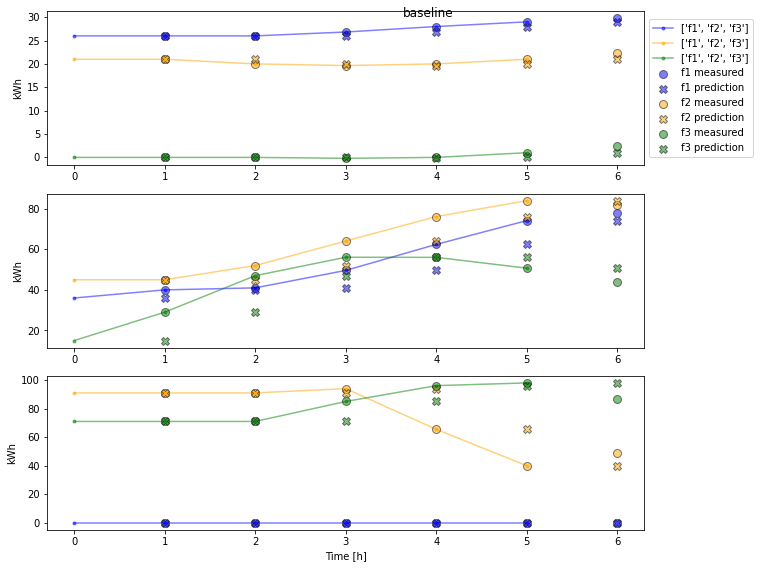

In [ ]:
val_performance = {}
test_performance = {}
column_indices = {name: i for i, name in enumerate(train_df.columns)}
baseline = training_camp_21_22.models.baseline.Baseline(
        label_indices=[column_indices[f] for f in ["f1", "f2", "f3"]])

baseline_history = train_evaluate_model(
    baseline, monthly_window, quadrimestral_window, val_performance, test_performance)


Plot models

In [ ]:
def plot_models(model_list):

    for model in model_list:
        model_plot_path = os.path.join(
            training_camp_21_22.config.plot_path,
            f"{model.name}_model.png")
        os.makedirs(model_plot_path, exist_ok=True)
        model.summary()
        tf.keras.utils.plot_model(
            model, model_plot_path, show_shapes=True)


# Baseline model

In [ ]:
app = test_features_ds_pd_2[test_features_ds_pd_2["date"] > "2022-05-01"]
app = app[["date", 'f1', 'f2', 'f3', 'month', 'user', "year"]]

In [ ]:
def baseline_predictions(df):
    df = df.drop(df[(df["month"]==6) & (df["year"]==2023)].index)
    return df

def create_kaggle_submission(df):

    def build_key(row):
        output = (
            str(row["user"]) + "_" +
            datetime.datetime.strftime(row["date"], "%m_%Y")) 
        return output

    df["key"] = df.apply(build_key, axis=1)
    df.drop(["date", "user", "month", "year"], axis=1, inplace=True)
    df.rename(
        columns={
            "key": "user_month_year",
            "f1": "next_month_f1",
            "f2": "next_month_f2",
            "f3": "next_month_f3"},
            inplace=True)
    return df

In [ ]:
baseline_predictions = baseline_predictions(app)
baseline_predictions = create_kaggle_submission(baseline_predictions)

# Neural Models must be inserted here

In [ ]:
# Insert a list of models here
# (linear, echo-state network, dense, multi_step_dense, long-short time memory)




In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [ ]:
pd.read_csv("/content/training_camp_21_22/data/task_2/train.csv").head()

,user_month_year,events,next_month_f1,next_month_f2,next_month_f3
0,0_07_2022,"[{""source"":""energy-simulazione"",""sourceVersion...",59.0,44.0,57.0
1,0_08_2022,"[{""source"":""energy-simulazione"",""sourceVersion...",32.0,31.0,37.0
2,0_09_2022,"[{""source"":""energy-simulazione"",""sourceVersion...",2.0,33.0,25.0
3,0_10_2022,"[{""source"":""energy-simulazione"",""sourceVersion...",5.0,40.0,20.0
4,0_11_2022,"[{""source"":""energy-simulazione"",""sourceVersion...",-0.0,54.0,27.0


In [52]:
# Parse the csv file with json entries

def convert_json_2_pd(json_input_path, train = True):
    """
    Read the csv file and extract from json events
    any feature useful to classify the consumer consumption profile 
    """
    csv_df = pd.DataFrame(columns=[
      "user_month",
      "fasciaF1ConsumoFatturato",
      "fasciaF2ConsumoFatturato",
      "fasciaF3ConsumoFatturato",
      "res_address_code",
      "res_address_value",
      "dom_address_code",
      "dom_address_value",
      "next_f1",
      "next_f2",
      "next_f3"
    ])


    d = {}
    truth = {}
    i = 0
    j = 0
    with open(json_input_path) as csvfile:

        reader = csv.reader(csvfile, delimiter=',')
        next(reader)

        for row in tqdm(reader):
          # iterate through bill

          for bill in json.loads(row[1]) :
            # read consumer id
            user_month = row[0]

            # billing_range
            billing_range = bill['customData']['billing_range']
            energy = bill['customData']['energy']
            addresses = bill['bamData']['items']['bamItem']['addresses']
            
            res_address_code = ''
            res_address_value = ''
            dom_address_code = ''
            dom_address_value = ''

            # build the fields
            for addr in addresses:
              if(addr['type']['code'] == '2'):
                res_address_code = addr['city']['code']
                res_address_value = addr['city']['value']
              elif(addr['type']['code'] == '6'):
                dom_address_code = addr['city']['code']
                dom_address_value = addr['city']['value']
            

            d[i] = {
              'user_month' : user_month,
              'month': int(user_month.split('_')[1]),
              'f1' : float(energy['fasciaF1ConsumoFatturato']),
              'f2' : float(energy['fasciaF2ConsumoFatturato']),
              'f3' : float(energy['fasciaF3ConsumoFatturato']),
              'res_address_code': res_address_code,
              'res_address_value': res_address_value,
              'dom_address_code': dom_address_code,
              'dom_address_value': dom_address_value,
              'next_f1' : float(row[2]) if train else None,
              'next_f2' : float(row[3]) if train else None,
              'next_f3' : float(row[4]) if train else None
            }
            i = i+1

          if(train):
            truth[j] = {'user_month' : user_month, 'next_f1' : row[2],
              'next_f2' : row[3],
              'next_f3' : row[4]}
            j += 1


    if(train):
      return pd.DataFrame.from_dict(d, "index"), pd.DataFrame.from_dict(truth, 'index')
    return  pd.DataFrame.from_dict(d, "index")

In [53]:
features_df, truth_df = convert_json_2_pd(json_input_path="/content/training_camp_21_22/data/task_2/train.csv")

770000it [02:10, 5882.50it/s]


In [ ]:
features_df.head()

,user_month,month,f1,f2,f3,res_address_code,res_address_value,dom_address_code,dom_address_value,next_f1,next_f2,next_f3
0,0_07_2022,7,56.0,42.0,60.0,E844,Malalbergo,E844,Malalbergo,59.0,44.0,57.0
1,0_08_2022,8,59.0,44.0,57.0,E844,Malalbergo,E844,Malalbergo,32.0,31.0,37.0
2,0_09_2022,9,32.0,31.0,37.0,E844,Malalbergo,E844,Malalbergo,2.0,33.0,25.0
3,0_10_2022,10,2.0,33.0,25.0,E844,Malalbergo,E844,Malalbergo,5.0,40.0,20.0
4,0_11_2022,11,5.0,40.0,20.0,E844,Malalbergo,E844,Malalbergo,-0.0,54.0,27.0


In [54]:
from sklearn.model_selection import train_test_split

# use only base features
X=features_df[['month', 'f1', 'f2', 'f3']]
#'res_address_code', 'res_address_value', 'dom_address_code','dom_address_value'

# define ground truths
y=features_df[['next_f1', 'next_f2', 'next_f3']]

# split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [55]:
X_train.head()

,month,f1,f2,f3
415516,9,52.0,50.0,37.0
107398,12,0.0,10.0,18.0
355084,11,18.0,50.0,30.0
670102,11,27.0,30.0,21.0
374653,11,24.0,23.0,22.0


In [56]:
from sklearn.preprocessing import StandardScaler

# define a scaler to normalize data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [57]:
# build the neural network

model = Sequential()
model.add(Dense(8, input_dim=4, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='linear'))
model.compile(loss='mae', optimizer='adam')

# fit the data
model.fit(X_train, y_train,epochs=6, verbose=1, validation_data=(X_val, y_val))


Epoch 1/6
16122/16122 [==============================] - 65s 4ms/step - loss: 8.2908 - val_loss: 7.2910
Epoch 2/6
16122/16122 [==============================] - 40s 3ms/step - loss: 7.3067 - val_loss: 7.2849
Epoch 3/6
16122/16122 [==============================] - 38s 2ms/step - loss: 7.3054 - val_loss: 7.2788
Epoch 4/6
16122/16122 [==============================] - 48s 3ms/step - loss: 7.3041 - val_loss: 7.2916
Epoch 5/6
16122/16122 [==============================] - 40s 2ms/step - loss: 7.3032 - val_loss: 7.2783
Epoch 6/6
16122/16122 [==============================] - 43s 3ms/step - loss: 7.3042 - val_loss: 7.3008


In [60]:
# extract data
test_df = convert_json_2_pd(json_input_path="/content/training_camp_21_22/data/task_2/test.csv", train=False)

# define test matrix
X_test = scaler.transform(test_df[['month', 'f1', 'f2', 'f3']])

110000it [00:19, 5513.96it/s]


In [61]:
# make prediction
pred = model.predict(X_test)

3438/3438 [==============================] - 5s 1ms/step


In [62]:
# explore prediction
pred

array([[ 0.8049984, 33.19956  , 33.459377 ],
       [ 0.5808215, 24.771086 , 35.293495 ],
       [ 2.4821596, 20.23807  , 33.261612 ],
       ...,
       [46.752388 , 46.207    , 35.08097  ],
       [43.061172 , 39.552013 , 31.375372 ],
       [35.97249  , 28.106995 , 17.243465 ]], dtype=float32)

In [63]:
def create_submission_for_dense(users, pred):
  ''' 
    define the submission structure starting from the keys list and predictions
  '''
  sub = {
      'user_month_year' : users,
      'next_month_f1': pred[:,0],
      'next_month_f2': pred[:,1],
      'next_month_f3': pred[:,2]
  }

  return pd.DataFrame.from_dict(sub)

# Submit solution to Kaggle competition

Create a termporary folder for submissions

In [66]:
!mkdir -p submissions

In [ ]:
baseline_predictions_path = "submissions/baseline.csv"
baseline_predictions.to_csv(baseline_predictions_path, index=False)

In [ ]:
!kaggle competitions submit -c pitc-2122-prediction -f "submissions/baseline.csv" -m "Baseline prediction"

100% 3.00M/3.00M [00:00<00:00, 6.90MB/s]
Successfully submitted to PITC 21/22 - Prediction

Submission for Dense Neural Network

In [67]:
path = "submissions/dense.csv"
create_submission_for_dense(test_df['user_month'], pred).to_csv(path, index = False)

In [68]:
!kaggle competitions submit -c pitc-2122-prediction -f "submissions/dense.csv" -m "Dense NN prediction"

100% 4.51M/4.51M [00:03<00:00, 1.29MB/s]
Successfully submitted to PITC 21/22 - Prediction